<a href="https://colab.research.google.com/github/inderjot29/Topic-Modeling/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have 4 tasks to do with the news articles dataset:

 1. Topic modeling: use this dataset to learn the different news topics that we have. 

 2.  Key-phrases extraction and ranking: identify best key phrases/ key words for each topic.

 3.  Emerging sub-topics identification: build topics distribution in time also a way to identify new and upcoming sub-topics within each topic. 

 4.  Sentiment Analysis: identify topic sentiment for each article and also the overall daily sentiment for each topic
We will apply Latent Dirichlet Allocation (LDA) to convert a set of new articles to a set of topics. 

 **News articles topic modelling** is an unsupervised ML 
  method that helps us discover hidden semantic structures in an article, 
 that allows us to learn topic representations of papers in a corpus. 
 The model can be applied to ay kinds of lables on documents, 
 such as tags on post on the website. 

### The Process ### 

    # - Pick the number of topics ahead of time.
    # - Each document is represented as a distribution over topics 
    # - Each topic is represented as a distribution over words. 
    
 The news article text data is just a bunch of unlabeled texts

In [1]:
### Topic Modelling of news articles ### 

""" 
        @author:Inderjot Kaur Ratol
        Dependencies: nltk, spaCy, gensim. 
        Based on tutorials by Susan Li, "Topic Modeling and Latent Dirichlet Allocation (LDA) in Python"
        at https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
"""

# Ignore
import warnings
warnings.filterwarnings('ignore')

### The Data ### 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import sys
import csv
import itertools
csv.field_size_limit(sys.maxsize)
PATH = "articles1.csv"
df_all = pd.read_csv(PATH,engine='python',encoding='utf8',error_bad_lines=False) # load into a data-frame 
#print("df\n",df_all.head())

# In order to keep it simple , and for reference, we will use only two of the columns
dfyear = df_all.groupby('year')
dfyear =pd.concat([x for _, x in itertools.islice(dfyear, 4)])
df_content = dfyear[['content']]
print("\ndf_content\n",df_content.head())
len(df_content)


df_content
                                                  content
38656  Washington (CNN) Pharmaceutical giant Merck wi...
32077   (CNN) Here’s a look at the life of Michelle O...
33217   (CNN) Here’s a look at the life of His Serene...
34009   (CNN) Here is a look at former Iranian Presid...
34039   (CNN) Green markets, farmers’ markets, fresh ...


315

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

data = []
 
for article in df_content.values:
    document = ' '.join(article)
    data.append(document)
 
NO_DOCUMENTS = len(data)
print(NO_DOCUMENTS)

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z][a-zA-Z]{2,}')
data_vectorized = vectorizer.fit_transform(data)

315


In [0]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
output_notebook()

svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [0]:

import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
output_notebook()

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Text(0, 0.5, 'Frequency')

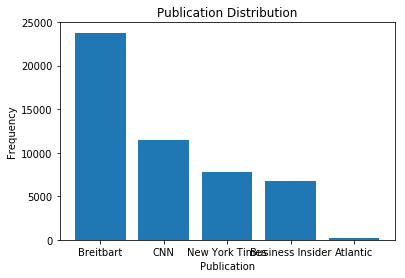

In [4]:
import matplotlib.pyplot as plt
# create a figure and axis 
fig, ax = plt.subplots() 
# count the occurrence of each class 
data = df_all['publication'].value_counts() 
# get x and y data 
points = data.index 
frequency = data.values 
# create bar chart 
ax.bar(points, frequency) 
# set title and labels 
ax.set_title('Publication Distribution') 
ax.set_xlabel('Publication') 
ax.set_ylabel('Frequency')

In [95]:
### Text Cleaning ### 

## Lemmatizing 
import re
import nltk
import gensim
import pickle
from gensim import models, corpora
from gensim.models import CoherenceModel
from smart_open import smart_open
nltk.download('stopwords')
nltk.download('punkt') 
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["see","photos","from","all","about", "cnn", "breitbart","publication","atlantic","here","look"])
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nlp_en = spacy.load("en_core_web_sm")

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]
  
# Build the bigram models
def bigrams(words, bi_min=15):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
  
  # Build the bigram models
def trigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=tri_min)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return trigram_mod
  
def make_bigrams(texts):
    bigram_mod = bigrams(texts)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram_mod = bigrams(texts)
    trigram_mod = trigrams(texts)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# create a filtered lemmas to exclude determiners (DET), adpositions(aka prepositions) (ADP), 
# punctuation (PUNCT), conjuctions (CONJ,CCONJ),subordinating conjunction(SCONJ), numerals (NUM), symbols (SYM), spaces (SPACE),
# auxillary (AUX), particle (PART), pronoun (PRON), helping verb (HVS), interjection(INTJ)
# and non-alpha tokens. We will also filter stopwords. 
# Full list can be found at https://spacy.io/api/annotation
# allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
# filter_tags = ["DET","ADP","PUNCT","CONJ","CCONJ","SCONJ","NUM","SYM","SPACE","AUX","PART","PRON","HVS","INTJ"]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        lemmas = [(token.text, token.lemma_) for token in doc if token.pos_ in allowed_postags 
                  and token.text.isalpha() and len( str(token.lemma_)) > 2]
        texts_out.append([lemma[1] for lemma in lemmas])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#Remove the articles with only photos, it causes our LDA to have lesser coherence
#filtered_docs = remove_photosArticles(df_content.values.tolist())
#data_words = list(sent_to_words(df_content[0:315].values.tolist()))
data_words = list(sent_to_words(df_content.values.tolist()))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
lemmatized_data = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Form Bigrams
#lemmatized_data = make_bigrams(lemmatized_data)
# Form Trigrams
lemmatized_data = make_trigrams(lemmatized_data)
filtered_data = []
for sent in lemmatized_data:
  filtered_data.append([token for token in sent if len(str(token))>3])

lemmatized_data = filtered_data
print(lemmatized_data[1])

['life', 'michelle_obama', 'wife', 'president_barack_obama', 'personal_birth_date', 'january', 'birth_place_chicago', 'illinois_birth_name', 'michelle', 'lavaughn', 'robinson', 'father', 'fraser', 'robinson', 'water', 'filtration', 'worker', 'mother', 'marian', 'shield', 'robinson', 'marriage', 'barack_obama', 'october', 'child', 'sasha', 'malia', 'education', 'princeton_university', 'harvard_university', 'religion', 'christian', 'fact', 'graduate', 'magna', 'laude', 'sociology', 'degree', 'princeton', 'meet', 'barack_obama', 'assign', 'mentor', 'sidley', 'austin', 'chicago', 'law_firm', 'father', 'suffer', 'eventually', 'multiple', 'sclerosis', 'timeline', 'associate', 'attorney', 'sidley', 'austin', 'chicago', 'assistant', 'chicago', 'mayor', 'richard', 'daley', 'assistant', 'commissioner', 'planning', 'development', 'found', 'executive_director', 'public', 'ally', 'chicago', 'associate', 'dean', 'student', 'service', 'university', 'chicago', 'director', 'university', 'community', 's

In [113]:
NUM_TOPICS = 15
 
# Create Dictionary
train_id2word = corpora.Dictionary(lemmatized_data)
train_id2word.filter_extremes(no_below=10, no_above=0.25,keep_n=100000)
train_id2word.compactify()

# Term Document Frequency
train_corpus = [train_id2word.doc2bow(text) for text in lemmatized_data]
#tfidf_model = gensim.models.TfidfModel(train_corpus)
#train_corpus = tfidf_model[train_corpus]
# Save the corpus with pickle
pickle.dump(train_corpus, smart_open('corpus.pkl', 'wb'))
train_id2word.save('dictionary.gensim') 
 
# Human readable format of corpus (term-frequency)
[[(train_id2word[id], freq) for id, freq in cp] for cp in train_corpus[:1]]


[[('ability', 1),
  ('activity', 1),
  ('agree', 2),
  ('agreement', 2),
  ('allegation', 1),
  ('approve', 2),
  ('assistant', 1),
  ('attorney_general', 1),
  ('behalf', 1),
  ('civil', 3),
  ('claim', 2),
  ('company', 2),
  ('corp', 1),
  ('cost', 1),
  ('criminal', 2),
  ('decision', 1),
  ('dollar', 1),
  ('drug', 1),
  ('effective', 1),
  ('false', 1),
  ('fine', 1),
  ('firm', 1),
  ('good', 1),
  ('government', 1),
  ('health_care', 1),
  ('illegal', 2),
  ('interim', 1),
  ('justice', 1),
  ('justice_department', 2),
  ('keep', 1),
  ('letter', 1),
  ('market', 1),
  ('medical', 2),
  ('medicine', 1),
  ('nearly', 2),
  ('official', 2),
  ('participate', 1),
  ('patient', 1),
  ('place', 1),
  ('plead_guilty', 1),
  ('promote', 1),
  ('purpose', 1),
  ('record', 2),
  ('relate', 1),
  ('remain', 1),
  ('resolve', 2),
  ('rule', 1),
  ('safe', 1),
  ('safety', 1),
  ('send', 1),
  ('settlement', 5),
  ('statement', 1),
  ('stem', 1),
  ('tony', 1),
  ('total', 1),
  ('warning'

In [0]:
# Build the LDA model
lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=NUM_TOPICS,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

lda_train.save('model_lda_train.gensim')

#View the topics in LDA model with Keyword Rankings
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next

In [111]:
from pprint import pprint
# Print the Keyword in the topics
pprint(lda_train.print_topics())
df_keywords_and_topics = pd.DataFrame(lda_train.print_topics())
doc_lda = lda_train[train_corpus]
df_keywords_and_topics

[(0,
  '0.032*"party" + 0.029*"prime_minister" + 0.019*"elect" + 0.019*"leader" + '
  '0.018*"minister" + 0.016*"vote" + 0.015*"corruption" + 0.015*"parliament" + '
  '0.014*"house" + 0.013*"resign"'),
 (1,
  '0.024*"attack" + 0.022*"isis" + 0.018*"iraq" + 0.014*"iraqi" + '
  '0.014*"force" + 0.013*"kill" + 0.013*"syria" + 0.013*"government" + '
  '0.012*"iran" + 0.012*"group"'),
 (2,
  '0.030*"plane" + 0.024*"military" + 0.021*"flight" + 0.017*"pilot" + '
  '0.014*"ship" + 0.014*"transfer" + 0.013*"search" + 0.013*"defense" + '
  '0.010*"qaeda" + 0.009*"helicopter"'),
 (3,
  '0.020*"award" + 0.016*"game" + 0.015*"play" + 0.014*"film" + 0.014*"team" + '
  '0.010*"television" + 0.010*"player" + 0.009*"star" + 0.008*"record" + '
  '0.008*"good"'),
 (4,
  '0.014*"israel" + 0.014*"peace" + 0.012*"government" + 0.012*"meet" + '
  '0.010*"agreement" + 0.010*"parliament" + 0.009*"prime_minister" + '
  '0.009*"kill" + 0.008*"area" + 0.008*"opposition"'),
 (5,
  '0.041*"market" + 0.025*"kill" +

,0,1
0,0,"0.032*""party"" + 0.029*""prime_minister"" + 0.019..."
1,1,"0.024*""attack"" + 0.022*""isis"" + 0.018*""iraq"" +..."
2,2,"0.030*""plane"" + 0.024*""military"" + 0.021*""flig..."
3,3,"0.020*""award"" + 0.016*""game"" + 0.015*""play"" + ..."
4,4,"0.014*""israel"" + 0.014*""peace"" + 0.012*""govern..."
5,5,"0.041*""market"" + 0.025*""kill"" + 0.018*""celebra..."
6,6,"0.025*""fire"" + 0.023*""capture"" + 0.019*""suspec..."
7,7,"0.021*""nato"" + 0.013*""france"" + 0.011*""visit"" ..."
8,8,"0.030*""king"" + 0.019*""white"" + 0.017*""parent"" ..."
9,9,"0.046*""good"" + 0.020*""black"" + 0.018*""richard""..."


#Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [112]:
# Compute Perplexity
print('\nPerplexity: ', lda_train.log_perplexity(train_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_train, texts=lemmatized_data, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.940083246551758

Coherence Score:  0.42137569361305294


In [6]:
!pip install -U scikit-learn 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(n_components=10, doc_topic_prior=None, topic_word_prior=None,
                                            learning_method=None, learning_decay=0.7, learning_offset=10.0,
                                            max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0,
                                            perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100,
                                           n_jobs=None, verbose=0, random_state=None),
       iid=True, n_jobs=-1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -282607.9051994569
Model Perplexity:  1646.5155202611293


In [0]:
# Build the LSI model
lsi_model = models.LsiModel(corpus=train_corpus, num_topics=NUM_TOPICS, id2word=train_id2word)

lsi_model.save('model_lsi.gensim')
# Get the topics 
print("LSI topics\n")
lsi_model.show_topics(num_topics=5)  # Showing only the top 5 topics

LSI topics



[(0,
  '0.104*"senate" + 0.087*"award" + 0.087*"attack" + 0.084*"kill" + 0.078*"murder" + 0.077*"film" + 0.076*"prime_minister" + 0.075*"federal" + 0.075*"court" + 0.074*"party"'),
 (1,
  '-0.255*"film" + -0.208*"award" + -0.184*"actor" + -0.164*"good" + -0.153*"movie" + 0.150*"prime_minister" + -0.138*"television" + -0.133*"star" + -0.131*"motion_picture" + -0.129*"winner"'),
 (2,
  '0.283*"senate" + -0.167*"parent" + 0.146*"award" + -0.135*"feel" + 0.119*"film" + 0.116*"prime_minister" + 0.108*"chairman" + 0.105*"party" + 0.094*"senator" + 0.094*"paul"'),
 (3,
  '-0.331*"race" + -0.321*"game" + -0.237*"player" + -0.226*"team" + -0.218*"league" + -0.202*"championship" + 0.175*"film" + -0.150*"season" + -0.135*"senate" + -0.132*"stake"'),
 (4,
  '0.248*"murder" + -0.165*"prime_minister" + 0.160*"trial" + 0.159*"judge" + 0.148*"file" + 0.143*"appeal" + 0.137*"court" + 0.136*"count" + -0.135*"israel" + -0.116*"race"')]

 # Visualize the topics-keywords
 
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [108]:
import gensim
!pip install pyLDAvis
# We can now output a visualization of the possible topics

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
lda = gensim.models.LdaModel.load('model_lda_train.gensim')

# Library to visualize the LDA
import pyLDAvis.gensim

# set up the display features 
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=train_id2word, corpus=train_corpus, texts=lemmatized_data, start=2, limit=60, step=6)

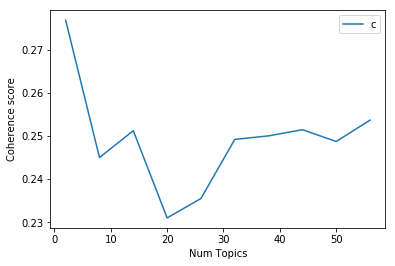

In [103]:
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.234
Num Topics = 8  has Coherence Value of 0.2224
Num Topics = 14  has Coherence Value of 0.2644
Num Topics = 20  has Coherence Value of 0.2312
Num Topics = 26  has Coherence Value of 0.2698
Num Topics = 32  has Coherence Value of 0.2694
Num Topics = 38  has Coherence Value of 0.2696
Num Topics = 44  has Coherence Value of 0.2435
Num Topics = 50  has Coherence Value of 0.2364
Num Topics = 56  has Coherence Value of 0.2256


#Sub-topic idenitification over a period of time using DTM

 Topics distribution in time also a way to identify new and upcoming sub-topics within each topic. 

In [0]:
#prepare the data for sub-topics identification by grouping the data based on year and month
df_year = df_all.groupby('year')
df_count_per_year = df_year.size().reset_index(name='count_per_year')
df_year_month = df_all.groupby(['year', 'month'])

#lets get the counts per year and per month
df_count_per_month = df_year_month.size().reset_index(name='count_per_month')
#df_count_per_month
df_count_per_year

,year,count_per_year
0,2011.0,1
1,2012.0,26
2,2013.0,212
3,2014.0,76
4,2015.0,3326
5,2016.0,28451
6,2017.0,17908


In [0]:
# setting up our imports

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy
from gensim.matutils import hellinger

In [0]:
time_slice = [1, 26, 212,76]

In [43]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=train_corpus, id2word=train_id2word, time_slice=time_slice, num_topics=NUM_TOPICS)
ldaseq.save('ldaseq.gensim')

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

#Visualizing Topics
The input parameter to print_topics is a time-slice option. By passing 0 we are seeing the topics in the 1st time-slice.

In [44]:
ldaseq.print_topics(time=0)

[[('attack', 0.02791070029387197),
  ('isis', 0.01603156752995125),
  ('kill', 0.014992323173054326),
  ('north_korea', 0.012722149004287066),
  ('official', 0.011486319896727683),
  ('military', 0.01072791682739827),
  ('strike', 0.010346203216340902),
  ('group', 0.008755324468798708),
  ('iran', 0.00825220256306685),
  ('force', 0.008027205611421773),
  ('syria', 0.007712290795275746),
  ('claim', 0.007587668581715776),
  ('video', 0.006911101713505568),
  ('government', 0.006884288541170302),
  ('agreement', 0.006680618177811065),
  ('russia', 0.006629685594051561),
  ('terrorist', 0.006547736768888791),
  ('mission', 0.006046542272487923),
  ('operation', 0.005970324538367295),
  ('nuclear', 0.005929062363273658)],
 [('senate', 0.017972954018649286),
  ('race', 0.01745323867789153),
  ('market', 0.01298492168190599),
  ('commission', 0.012114502057238869),
  ('nato', 0.011715270246335644),
  ('committee', 0.010541485296286277),
  ('georgia', 0.010022505539412516),
  ('internationa

We can see 10 different fairly well defined topics:

1.   List item
2.   List item



#Looking for Topic Evolution
To fix a topic and see it evolve, use print_topic_times. The input parameter is the topic_id In this case, we are looking at the evolution of the technology topi

In [45]:
ldaseq.print_topic_times(topic=0)

[[('attack', 0.02791070029387197),
  ('isis', 0.01603156752995125),
  ('kill', 0.014992323173054326),
  ('north_korea', 0.012722149004287066),
  ('official', 0.011486319896727683),
  ('military', 0.01072791682739827),
  ('strike', 0.010346203216340902),
  ('group', 0.008755324468798708),
  ('iran', 0.00825220256306685),
  ('force', 0.008027205611421773),
  ('syria', 0.007712290795275746),
  ('claim', 0.007587668581715776),
  ('video', 0.006911101713505568),
  ('government', 0.006884288541170302),
  ('agreement', 0.006680618177811065),
  ('russia', 0.006629685594051561),
  ('terrorist', 0.006547736768888791),
  ('mission', 0.006046542272487923),
  ('operation', 0.005970324538367295),
  ('nuclear', 0.005929062363273658)],
 [('attack', 0.028163836643807155),
  ('isis', 0.01656833507872791),
  ('kill', 0.014962569895755768),
  ('north_korea', 0.012605203578997939),
  ('official', 0.011586586844580086),
  ('military', 0.010746101093162664),
  ('strike', 0.010412024121489328),
  ('group', 0.

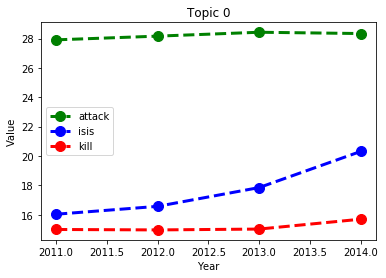

In [48]:
import matplotlib.pyplot as plt 

time_series_topic_0 = ldaseq.print_topic_times(topic=0)
    
# line 1 points 
x1 = [2011,2012,2013,2014]
y1 = [[freq*1000 for word, freq in cp if word=='attack'] for cp in time_series_topic_0]
# plotting the line 1 points  
plt.plot(x1, y1, label = "attack",color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='green', markersize=10) 
  
# line 2 points 
x2 = [2011,2012,2013,2014] 
y2 = [[freq*1000 for word, freq in cp if word=='isis'] for cp in time_series_topic_0]
# plotting the line 2 points  
plt.plot(x2, y2, label = "isis", color='blue', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=10) 

# line 3 points 
x3 = [2011,2012,2013,2014]
y3 = [[freq*1000 for word, freq in cp if word=='kill'] for cp in time_series_topic_0]
# plotting the line 1 points  
plt.plot(x3, y3, label = "kill",color='red', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='red', markersize=10)
  
# naming the x axis 
plt.xlabel('Year') 
# naming the y axis 
plt.ylabel('Value') 
# giving a title to my graph 
plt.title('Topic 0') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show()

#Document - Topic Proportions
The function doc_topics checks the topic proportions on documents already trained on. It accepts the document number in the corpus as an input.

Let's pick up document number 300 arbitrarily and have a look.

In [50]:
# to check Document - Topic proportions, use `doc-topics`
words = [train_id2word[word_id] for word_id, count in train_corpus[300]]
print (words)

doc = ldaseq.doc_topics(300) # check the 300th document in the corpuses topic distribution
print (doc)

['celebrity', 'twitter']
[0.00480769 0.00480769 0.00480769 0.96634615 0.00480769 0.00480769
 0.00480769 0.00480769]


#Choosing your best Dynamic Topic Model
Like we've been going on and on before, the advantage in having a python port is the transparency with which you can train your DTM. We'll go over two key ideas: changing variance, and changing suff stats.

Chain Variance
One of the key aspects of topic evolution is how fast/slow these topics evolve. And this is where the factor of variance comes in. By setting the chain_variance input to the DTM model higher, we can tweak our topic evolution. The default value is 0.005. (this is the value suggested by Blei in his tech talk and is the default value in the C++ code)

Let us see a small example illustrating the same. Let's first see the evolution of values for the first time-slice

In [51]:
ldaseq.print_topic_times(1)

[[('senate', 0.017972954018649286),
  ('race', 0.01745323867789153),
  ('market', 0.01298492168190599),
  ('commission', 0.012114502057238869),
  ('nato', 0.011715270246335644),
  ('committee', 0.010541485296286277),
  ('georgia', 0.010022505539412516),
  ('international', 0.009062949992574065),
  ('governor', 0.008582071460767563),
  ('chairman', 0.008416297042534684),
  ('federal', 0.007336608387571031),
  ('appoint', 0.006647239193355947),
  ('new_york', 0.006574995929080581),
  ('unite_state', 0.006543818229955533),
  ('senator', 0.00644422833229401),
  ('paul', 0.006012082204184365),
  ('school', 0.005974026358115803),
  ('celebrate', 0.005762772941457893),
  ('economic', 0.0053799259119861114),
  ('france', 0.005209954816816877)],
 [('senate', 0.018128562497768345),
  ('race', 0.017691854276169008),
  ('market', 0.012632501159695865),
  ('commission', 0.012210222171458873),
  ('nato', 0.011773754766687612),
  ('committee', 0.01059382768884136),
  ('georgia', 0.009927396031661023)

In [52]:
ldaseq_chain = ldaseqmodel.LdaSeqModel(corpus=train_corpus, id2word=train_id2word, time_slice=time_slice, num_topics=NUM_TOPICS, chain_variance=0.05)
ldaseq_chain.save('ldaseq_chain.gensim')
ldaseq_chain.print_topic_times(2)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[[('prison', 0.01887207513171017),
  ('court', 0.015128790248273823),
  ('sentence', 0.013205910656354358),
  ('trial', 0.012762054073776036),
  ('murder', 0.010929419261128134),
  ('arrest', 0.009769293443678358),
  ('north_korea', 0.009761404082041979),
  ('convict', 0.008688495057917148),
  ('file', 0.008468438668129859),
  ('iran', 0.008459128429141965),
  ('appeal', 0.008400725307878939),
  ('count', 0.008035271200694654),
  ('judge', 0.007984244384428347),
  ('execution', 0.007752341007785533),
  ('case', 0.007294280088554313),
  ('death_penalty', 0.007095810866335129),
  ('plead_guilty', 0.006824936436599643),
  ('supreme_court', 0.006664891506592181),
  ('bombing', 0.0065851486291419225),
  ('rule', 0.0062082496373213)],
 [('prison', 0.018914013494614454),
  ('court', 0.015153378653063427),
  ('sentence', 0.013225953755444273),
  ('trial', 0.012777987426691444),
  ('murder', 0.010951257942158538),
  ('arrest', 0.009781336679748714),
  ('north_korea', 0.009774142597945337),
  ('

#Visualising Dynamic Topic Models
Let us use pyLDAvis to visualise both the DTM wrapper and DTM python port. With the new DTMvis methods it is now very straightforward to visualise DTM for a particular time-slice.

In [55]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

lda_seq = ldaseqmodel.LdaSeqModel.load('ldaseq.gensim')
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
doc_topic, topic_term, doc_lengths, term_frequency, vocab = lda_seq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

#Topic Coherence for LDASEQ (DTM)

In [56]:
from gensim.models.coherencemodel import CoherenceModel
import pickle

# we just have to specify the time-slice we want to find coherence for.
topics_dtm = ldaseq.dtm_coherence(time=2)

# running u_mass coherence on our model
cm_DTM = CoherenceModel(topics=topics_dtm, corpus=corpus, dictionary=dictionary, coherence='u_mass')

print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.8726941109936819


#Sentiment Analysis with AFINN Lexicon

In [87]:
# initialize afinn sentiment analyzer
!pip install afinn
import afinn
from afinn import Afinn
af = Afinn()

topics_list=[]
for (topic, keyword) in df_keywords_and_topics.values:
    w_k = keyword.split('+')
    w_k = [word.strip() for word in w_k]
    only_keywords=[]
    for word in w_k:
        only_keywords.append(word[6:].replace('"',' '))
    topics_list.append(''.join(only_keywords))

print(topics_list)
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(topic) for topic in topics_list]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([[0,1,2,3,4,5,6,7], sentiment_scores, sentiment_category]).T
df.columns = ['news_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_topic']).describe()

[' game  team  high_school  kill  school  play  georgia  student  player  prison ', ' north_korea  season  nuclear  wood  soldier  miss  battle  open  third  camera ', ' kill  fire  race  victim  strike  market  food  area  owner  player ', ' isis  iraq  force  government  military  kill  iraqi  syria  attack  leader ', ' award  good  film  actor  star  television  movie  execution  king  record ', ' veteran  court  murder  right  supreme_court  file  case  trial  federal  judge ', ' attack  senate  court  trial  official  file  prison  commission  government  tell ', ' would  tell  want  parent  study  could  come  think  live  even ']


sentiment_score                                  
                     count mean std  min  25%  50%  75%  max
news_topic                                                  
0                      1.0 -5.0 NaN -5.0 -5.0 -5.0 -5.0 -5.0
1                      1.0 -3.0 NaN -3.0 -3.0 -3.0 -3.0 -3.0
2                      1.0 -9.0 NaN -9.0 -9.0 -9.0 -9.0 -9.0
3                      1.0 -4.0 NaN -4.0 -4.0 -4.0 -4.0 -4.0
4                      1.0  6.0 NaN  6.0  6.0  6.0  6.0  6.0
5                      1.0 -2.0 NaN -2.0 -2.0 -2.0 -2.0 -2.0
6                      1.0 -3.0 NaN -3.0 -3.0 -3.0 -3.0 -3.0
7                      1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0

  Created wheel for sns: filename=sns-0.1-cp36-none-any.whl size=2664 sha256=66f6b05ecfc989a724869af514a08282c1911fa34856ca81b1501822f02950a5
  Stored in directory: /root/.cache/pip/wheels/be/a5/d8/4390400ed430c8186a6af96dbb1cc7d0a00a5dee15d268b627
Successfully built sns


AttributeError: ignored

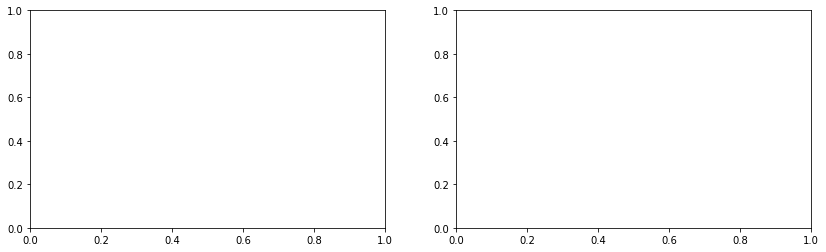

In [90]:
!pip install sns
import sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_topic', y="sentiment_score", 
                   hue='news_topic', data=df, ax=ax1)
bp = sns.boxplot(x='news_topic', y="sentiment_score", 
                 hue='news_topic', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

In [92]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(topic).sentiment.polarity, 3) for topic in topics_list]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([[0,1,2,3,4,5,6,7], sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_topic']).describe()

sentiment_score                                              
                     count   mean std    min    25%    50%    75%    max
news_topic                                                              
0                      1.0 -0.400 NaN -0.400 -0.400 -0.400 -0.400 -0.400
1                      1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000
2                      1.0 -0.075 NaN -0.075 -0.075 -0.075 -0.075 -0.075
3                      1.0 -0.100 NaN -0.100 -0.100 -0.100 -0.100 -0.100
4                      1.0  0.700 NaN  0.700  0.700  0.700  0.700  0.700
5                      1.0  0.143 NaN  0.143  0.143  0.143  0.143  0.143
6                      1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000
7                      1.0  0.136 NaN  0.136  0.136  0.136  0.136  0.136